# Amazon mobile phones reviews

O dataset de reviews de celulares da Amazon foi baixado do [data.world](https://data.world/opensnippets/amazon-mobile-phones-reviews).

A ideia aqui é pegar os reviews de vários produtos, e tentar entender o que os usuários mais estão falando sobre eles.

In [1]:
import pandas as pd
import numpy as np
import re
import json
import string
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download("stopwords")
#nltk.download('rslp')

from nltk import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy

### Dados

In [2]:
reviews_dataset = pd.read_json('data/amazon_one_plus_reviews.json', encoding='utf-8')

In [3]:
reviews_dataset.shape

(30612, 20)

In [4]:
reviews_dataset.columns

Index(['product', 'product_company', 'profile_name', 'review_title',
       'review_rating', 'review_text', 'helpful_count', 'total_comments',
       'review_country', 'reviewed_at', 'url', 'crawled_at', '_id',
       'verified_purchase', 'color', 'style_name', 'size_name', 'category',
       'sub_category', 'images'],
      dtype='object')

Este dataset contém 30612 registros e 20 atributos (colunas). E aparentemente não há registros vazios, mas é possível verificar que há alguns registros com o valor `na` como string, é necessário tratar isso mais adiante.

In [5]:
reviews_dataset.head()

,product,product_company,profile_name,review_title,review_rating,review_text,helpful_count,total_comments,review_country,reviewed_at,url,crawled_at,_id,verified_purchase,color,style_name,size_name,category,sub_category,images
0,"OnePlus Nord 5G (Gray Onyx, 8GB RAM, 128GB Sto...",OnePlus,Nikhil,*Read before you buy!!*,5.0 out of 5 stars,"\n Yea..pre-ordered on 28 July, got it on 4 A...",721 people found this helpful,3,India,2020-08-04,https://www.amazon.in/product-reviews/B08695ZS...,2020-10-18 11:23:47,45ca015a-2e39-5650-a174-ba966dd1e51f,Verified Purchase,Marble Blue,8GB RAM + 128GB Storage,na,electronics,mobiles,[https://images-na.ssl-images-amazon.com/image...
1,"OnePlus Nord 5G (Gray Onyx, 8GB RAM, 128GB Sto...",OnePlus,Amit,Near to mid range Perfection,5.0 out of 5 stars,"\n Got it delivered yesterday , used for abou...",436 people found this helpful,1,India,2020-08-03,https://www.amazon.in/product-reviews/B08695ZS...,2020-10-18 11:23:47,6820f8ae-f3cd-5783-b826-5e5805376047,Verified Purchase,na,na,na,electronics,mobiles,[]
2,"OnePlus Nord 5G (Gray Onyx, 8GB RAM, 128GB Sto...",OnePlus,aishwarya,Great price!,5.0 out of 5 stars,\n An amazing phone!,322 people found this helpful,1,India,2020-08-04,https://www.amazon.in/product-reviews/B08695ZS...,2020-10-18 11:23:47,bea91c43-8d65-5ef5-ab04-595a5f5cc542,Verified Purchase,na,na,na,electronics,mobiles,[https://images-na.ssl-images-amazon.com/image...
3,"OnePlus Nord 5G (Gray Onyx, 8GB RAM, 128GB Sto...",OnePlus,vasu a.,Beast in OnePlus.,5.0 out of 5 stars,\n Brilliant..,243 people found this helpful,7,India,2020-08-02,https://www.amazon.in/product-reviews/B08695ZS...,2020-10-18 11:23:47,76f68b53-5c52-56b2-9727-a5ab8c4bb4ff,Verified Purchase,na,na,na,electronics,mobiles,[https://images-na.ssl-images-amazon.com/image...
4,"OnePlus Nord 5G (Gray Onyx, 8GB RAM, 128GB Sto...",OnePlus,Amazon Customer,Changed to Nord from 6t,5.0 out of 5 stars,\n I was skeptical about changing from One pl...,109 people found this helpful,2,India,2020-08-04,https://www.amazon.in/product-reviews/B08695ZS...,2020-10-18 11:23:47,22228681-b884-56a1-b04e-87167f6f76e6,Verified Purchase,na,na,na,electronics,mobiles,[]


In [6]:
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30612 entries, 0 to 30611
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product            30612 non-null  object        
 1   product_company    30612 non-null  object        
 2   profile_name       30612 non-null  object        
 3   review_title       30612 non-null  object        
 4   review_rating      30612 non-null  object        
 5   review_text        30612 non-null  object        
 6   helpful_count      30612 non-null  object        
 7   total_comments     30612 non-null  int64         
 8   review_country     30612 non-null  object        
 9   reviewed_at        30612 non-null  datetime64[ns]
 10  url                30612 non-null  object        
 11  crawled_at         30612 non-null  datetime64[ns]
 12  _id                30612 non-null  object        
 13  verified_purchase  30612 non-null  object        
 14  color 

### Tratar dados

Para a finalidade desta análise, alguns destes atributos não serão necessários, como a imagem, as categorias (até porque se sabe que todos os produtos são celulares), a data do scrapping, a imagem.

O país até seria interessante manter, mas este dataset trabalha com quase todos os usuários de um único país, a Índia, então faz mais sentido ignorar essa informação.

In [7]:
reviews_dataset['review_country'].unique()

array([' India ', ' Saudi Arabia ', ' Mexico ', ' Italy '], dtype=object)

In [8]:
reviews_dataset.value_counts(['review_country'])

review_country
 India            30609
 Italy                1
 Mexico               1
 Saudi Arabia         1
dtype: int64

In [9]:
reviews_dataset.drop([
    'helpful_count', 'total_comments', 'url', 'crawled_at', 'verified_purchase', 'color', 'category', 'sub_category', 'images',
'review_country', 'reviewed_at', 'profile_name'], 
    axis=1, inplace=True)

In [10]:
# Foi eliminado metade das colunas

reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30612 entries, 0 to 30611
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product          30612 non-null  object
 1   product_company  30612 non-null  object
 2   review_title     30612 non-null  object
 3   review_rating    30612 non-null  object
 4   review_text      30612 non-null  object
 5   _id              30612 non-null  object
 6   style_name       30612 non-null  object
 7   size_name        30612 non-null  object
dtypes: object(8)
memory usage: 1.9+ MB


A principal informação que se deseja usar, é o `review_text` que é a avaliação de cada usuário, além do atributo `product` que é o produto alvo da análise e ainda o `product_company` que é a marca. Sendo assim, é necessário verificar se existem registros `na` nestas colunas e ceifá-los!

In [11]:
len(reviews_dataset[
    (reviews_dataset['review_text'] == 'na') | 
    (reviews_dataset['product'] == 'na') |
    (reviews_dataset['product_company'] == 'na')
])

0

In [12]:
reviews_dataset['product'].unique()

array(['OnePlus Nord 5G (Gray Onyx, 8GB RAM, 128GB Storage)',
       'Redmi Note 8 (Neptune Blue, 4GB RAM, 64GB Storage)',
       'Redmi Note 9 Pro (Aurora Blue, 4GB RAM, 64GB Storage) - Latest 8nm Snapdragon 720G & Alexa Hands-Free | 6 Months No Cost EMI'],
      dtype=object)

Ao buscar o nome de cada produto, verificou-se que tais nomes são bem grandes e podem ser simplificados. Para melhorar a visualização será criado uma nova coluna com o nome e o modelo do celular, sem as especificações extras.

In [13]:
reviews_dataset.loc[reviews_dataset['product'] == 'OnePlus Nord 5G (Gray Onyx, 8GB RAM, 128GB Storage)', 'product_simple_name'] = 'OnePlus Nord 5G'
reviews_dataset.loc[reviews_dataset['product'] == 'Redmi Note 8 (Neptune Blue, 4GB RAM, 64GB Storage)', 'product_simple_name'] = 'Redmi Note 8'
reviews_dataset.loc[reviews_dataset['product'] == 'Redmi Note 9 Pro (Aurora Blue, 4GB RAM, 64GB Storage) - Latest 8nm Snapdragon 720G & Alexa Hands-Free | 6 Months No Cost EMI', 'product_simple_name'] = 'Redmi Note 9 Pro'

Ao verificar a coluna `review_rating`, é possível verificar que as notas estão num formato de texto, e podem ser convertidas em número.

In [14]:
reviews_dataset.value_counts(['review_rating'])

review_rating     
5.0 out of 5 stars    13967
4.0 out of 5 stars     8537
3.0 out of 5 stars     4172
1.0 out of 5 stars     2088
2.0 out of 5 stars     1848
dtype: int64

In [15]:
reviews_dataset.loc[reviews_dataset['review_rating'] == '5.0 out of 5 stars', 'review_rating'] = 5
reviews_dataset.loc[reviews_dataset['review_rating'] == '4.0 out of 5 stars', 'review_rating'] = 4
reviews_dataset.loc[reviews_dataset['review_rating'] == '3.0 out of 5 stars', 'review_rating'] = 3
reviews_dataset.loc[reviews_dataset['review_rating'] == '2.0 out of 5 stars', 'review_rating'] = 2
reviews_dataset.loc[reviews_dataset['review_rating'] == '1.0 out of 5 stars', 'review_rating'] = 1

In [16]:
# Ver uma linha para saber como ficou

reviews_dataset[:1]

,product,product_company,review_title,review_rating,review_text,_id,style_name,size_name,product_simple_name
0,"OnePlus Nord 5G (Gray Onyx, 8GB RAM, 128GB Sto...",OnePlus,*Read before you buy!!*,5,"\n Yea..pre-ordered on 28 July, got it on 4 A...",45ca015a-2e39-5650-a174-ba966dd1e51f,8GB RAM + 128GB Storage,na,OnePlus Nord 5G


### Explorar dados

O dataset contém as reviews de usuários de três celulares, um da OnePlus e mais dois da Redmi (linha da Xiaomi).

In [17]:
reviews_dataset['product_company'].unique()

array(['OnePlus', 'Redmi'], dtype=object)

In [18]:
reviews_dataset.value_counts(['product_simple_name'])

product_simple_name
Redmi Note 8           13934
OnePlus Nord 5G         9469
Redmi Note 9 Pro        7209
dtype: int64

São 3 modelos de celular com muitas avaliações cada.

In [19]:
reviews_dataset.value_counts(['review_rating'])

review_rating
5                13967
4                 8537
3                 4172
1                 2088
2                 1848
dtype: int64

A maioria das avaliações gerais são positivas.

In [20]:
reviews_dataset.value_counts(['review_rating'])

review_rating
5                13967
4                 8537
3                 4172
1                 2088
2                 1848
dtype: int64

Contagem de ratings do modelo `OnePlus Nord 5G`

In [21]:
reviews_dataset.loc[reviews_dataset['product_simple_name'] == 'OnePlus Nord 5G'].value_counts(['review_rating'])

review_rating
5                4796
4                2064
1                1198
3                 941
2                 470
dtype: int64

Contagem de ratings do modelo `Redmi Note 8`

In [22]:
reviews_dataset.loc[reviews_dataset['product_simple_name'] == 'Redmi Note 8'].value_counts(['review_rating'])

review_rating
4                5010
5                5010
3                2719
2                1155
1                  40
dtype: int64

Contagem de ratings do modelo `Redmi Note 9 Pro`

In [23]:
reviews_dataset.loc[reviews_dataset['product_simple_name'] == 'Redmi Note 9 Pro'].value_counts(['review_rating'])

review_rating
5                4161
4                1463
1                 850
3                 512
2                 223
dtype: int64

Plotar gráfico comparando as notas dos usuários para cada produto.

*A visão do gráfico ficou bem legal, posso descartar algumas células acima depois.*

In [24]:
df_group_product_ratings = reviews_dataset.groupby(['product_simple_name', 'review_rating'])['product'].count().reset_index()

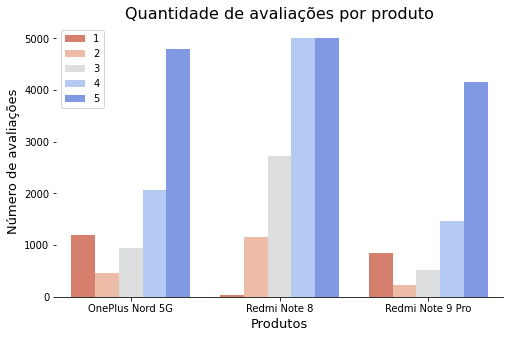

In [25]:
#df_group_product_ratings.plot.bar(stacked=True);

plt.figure(figsize=(8,5))
sns.barplot(y='product',x='product_simple_name', hue='review_rating',
            data=df_group_product_ratings, palette="coolwarm_r")
sns.despine(left=True)

plt.title('Quantidade de avaliações por produto', fontsize=16)
plt.xlabel('Produtos', fontsize=13)
plt.ylabel('Número de avaliações', fontsize=13)
plt.legend(loc='best')
plt.show();

Os três aparelhos são bem avaliados no geral, mas olhando para cada um deles nota-se algumas diferenças:
    
- **OnePlus Nord 5G**: As notas 5 somadas superam todas as demais, as notas 4 vem logo em seguida, mas sua terceira maior avaliação é de mais de 1000 pessoas. Olhando assim, parece ser um produto que muita gente ou gostou muito, ou não gostou nenhum pouco;

- **Redmi Note 8**: Disparado o melhor avaliado, com muitas notas 4 e 5. Aqui, talvez valha a pena entender porque tanta gente deu 4, mas não 5, talvez demostre que tem algo nele que poderia ser melhor na visão dos usuários. As avaliações 1, são baixíssimas!

- **Redmi Note 9 Pro**: Segue um pouco a tendência do primeiro produto avaliado, com muitas notas altas, e proporcionalmente um bom número de pessoas que não gostaram nem um pouco. As notas médias também são baixas.

### Pré-processamento da NLP


- Tokenização
- Capitalização
- Remover stop words
- Remover números
- Remover pontuações
- Remover acentos
- Remover letras sozinhas
- Lematização

In [28]:
def obter_corpus(reviews):
    """
    Recebe o array com as reviews e retorna o corpus
    """
    corpus = ''
    for rev in reviews:
        corpus += rev
    return corpus

###

def preprocessamento(corpus, stop_words = []):
    tokens = re.findall(r"\w+(?:'\w+)?|[^\w\s]", corpus) # converte o corpus em tokens
    
    n_tokens = []
    for txt in tokens:
        texto = txt.lower() # Converte para minúsculo
        if stop_words: # remove as stop words
            if texto in stop_words:
                continue
        texto = re.sub(r'\d', '', texto) # remove os números
        if texto in string.punctuation: # remove as pontuações
            continue
        texto = unidecode(texto) # remover os acentos
        if len(texto) > 1: # adicionar palavras maiores que 1 letra
            n_tokens.append(texto)
        
    return n_tokens

###

def plot_frequencia_tokens(tokens):
    fd_words = FreqDist(tokens)
    fd_words.plot(20)

In [47]:
reviews_oneplus_nord = reviews_dataset[reviews_dataset['product_simple_name'] == 'OnePlus Nord 5G']['review_text']
reviews_redmi8 = reviews_dataset[reviews_dataset['product_simple_name'] == 'Redmi Note 8']['review_text']
reviews_redmi9 = reviews_dataset[reviews_dataset['product_simple_name'] == 'Redmi Note 9 Pro']['review_text']

In [48]:
corpus_oneplus_nord = obter_corpus(reviews_oneplus_nord)
tokens_oneplus_nord = preprocessamento(corpus_oneplus_nord, stopwords.words('english'))

corpus_redmi8 = obter_corpus(reviews_redmi8)
tokens_redmi8 = preprocessamento(corpus_redmi8, stopwords.words('english'))

corpus_redmi9 = obter_corpus(reviews_redmi9)
tokens_redmi9 = preprocessamento(corpus_redmi9, stopwords.words('english'))

Tamanho: One Plus Nord / 83356


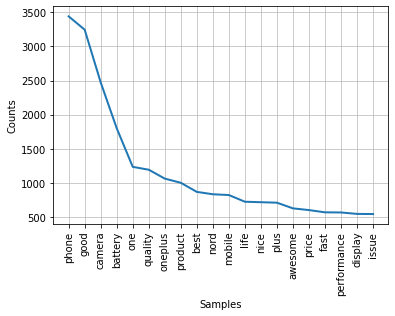

Tamanho: Redmi 8 / 96351


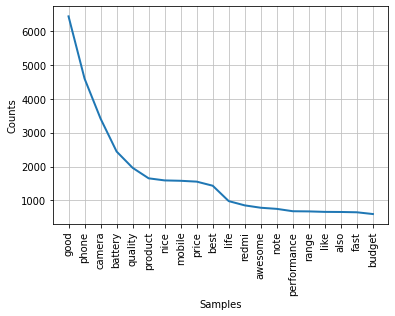

Tamanho: Redmi 9 / 47256


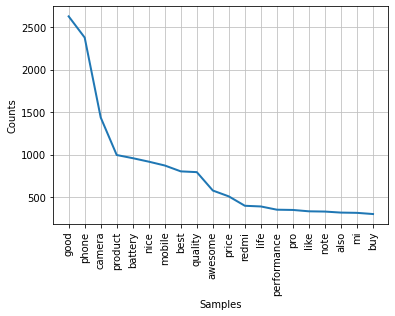

In [51]:
print("Tamanho: One Plus Nord /", len(tokens_oneplus_nord))
plot_frequencia_tokens(tokens_oneplus_nord)

print("Tamanho: Redmi 8 /", len(tokens_redmi8))
plot_frequencia_tokens(tokens_redmi8)

print("Tamanho: Redmi 9 /", len(tokens_redmi9))
plot_frequencia_tokens(tokens_redmi9)

#### Lemmatização

In [34]:
def lematizar_tokens_spacy(tokens):
    nlp = spacy.load("en_core_web_md") 
    
    str_tokens = ' '.join(tokens) 
    doc = nlp(str_tokens)
    tokens_lemm = [token.lemma_ for token in doc]
    return tokens_lemm

###

def lematizar_tokens_nltk(tokens):
    """
    Essa função é mais rápida que a anterior e normaliza mais termos também
    """
    lemmatizer = WordNetLemmatizer()
    
    lem_words = [lemmatizer.lemmatize(x) for x in (tokens)]
    return lem_words

In [53]:
%%time

tokens_oneplus_nord_nltk_lema = lematizar_tokens_nltk(tokens_oneplus_nord)
tokens_oneplus_nord_spacy_lema = lematizar_tokens_spacy(tokens_oneplus_nord)

Wall time: 1min 1s


Tamanho 83356


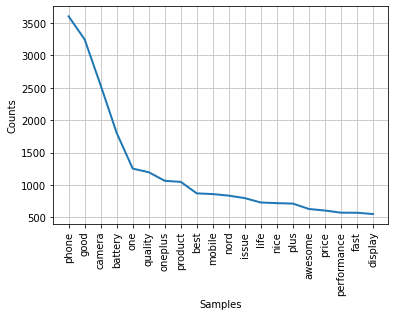

Tamanho 83940


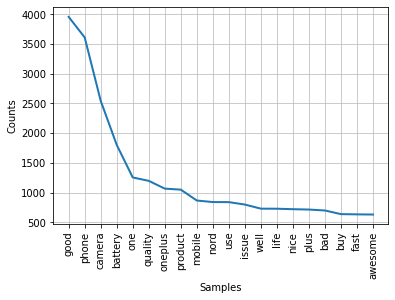

In [56]:
# plot tokens_lemm nltk e spacy

print("Tamanho", len(tokens_oneplus_nord_nltk_lema))
plot_frequencia_tokens(tokens_oneplus_nord_nltk_lema)
print("Tamanho", len(tokens_oneplus_nord_spacy_lema))
plot_frequencia_tokens(tokens_oneplus_nord_spacy_lema)

In [54]:
%%time

tokens_redmi8_nltk_lema = lematizar_tokens_nltk(tokens_redmi8)
tokens_redmi8_spacy_lema = lematizar_tokens_spacy(tokens_redmi8)

Wall time: 1min 3s


Tamanho 96351


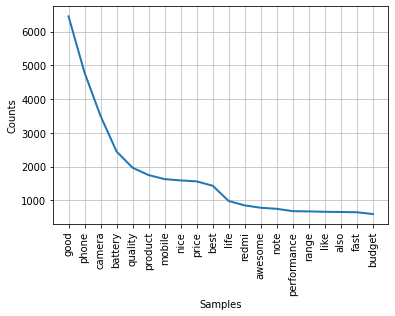

Tamanho 96916


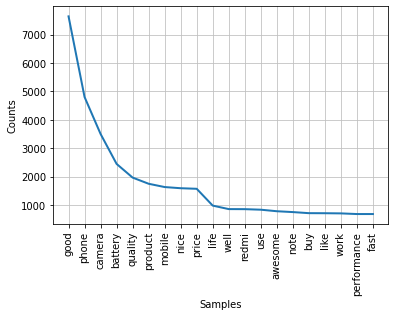

In [57]:
print("Tamanho", len(tokens_redmi8_nltk_lema))
plot_frequencia_tokens(tokens_redmi8_nltk_lema)
print("Tamanho", len(tokens_redmi8_spacy_lema))
plot_frequencia_tokens(tokens_redmi8_spacy_lema)

In [55]:
%%time

tokens_redmi9_nltk_lema = lematizar_tokens_nltk(tokens_redmi9)
tokens_redmi9_spacy_lema = lematizar_tokens_spacy(tokens_redmi9)

Wall time: 20 s


Tamanho 47256


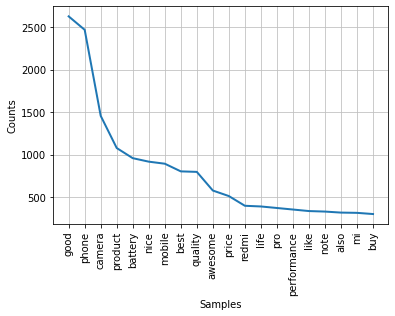

Tamanho 47529


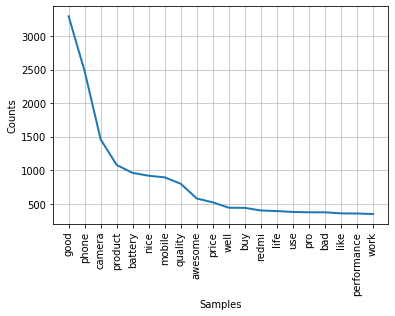

In [58]:
print("Tamanho", len(tokens_redmi9_nltk_lema))
plot_frequencia_tokens(tokens_redmi9_nltk_lema)
print("Tamanho", len(tokens_redmi9_spacy_lema))
plot_frequencia_tokens(tokens_redmi9_spacy_lema)

Tem várias palavras que aparecem com frequência nos 3 casos: good, phone, camera, product, battery, awesome, price, etc.

Na comparação entre a lematização por nltk ou spacy, as palavras mais frequentes mudam de ordem e até algumas aparecem num gráfico e não no outro.

In [60]:
x = preprocessamento("Hello1 ! I am a good boy") 
x

['hello', 'am', 'good', 'boy']

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
classificador = MultinomialNB()
tfidf_vector = TfidfVectorizer(tokenizer = preprocess)

# Create pipeline
pipe = Pipeline([('tfidf',tfidf_vector), ('classifier', classificador)])

# model generation
pipe.fit(df['Phrase'],df['Sentiment'])

---

### Referências

https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0

https://data.world/opensnippets/amazon-mobile-phones-reviews
